In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine,reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
first_row_meas = session.query(Measurement).first()
first_row_stat = session.query(Station).first()
first_row_meas.__dict__,first_row_stat.__dict__

({'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bdae760d30>,
  'station': 'USC00519397',
  'id': 1,
  'tobs': 65.0,
  'date': '2010-01-01',
  'prcp': 0.08},
 {'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1bdae7a52b0>,
  'longitude': -157.8168,
  'latitude': 21.2716,
  'station': 'USC00519397',
  'elevation': 3.0,
  'name': 'WAIKIKI 717.2, HI US',
  'id': 1})

# Exploratory Climate Analysis

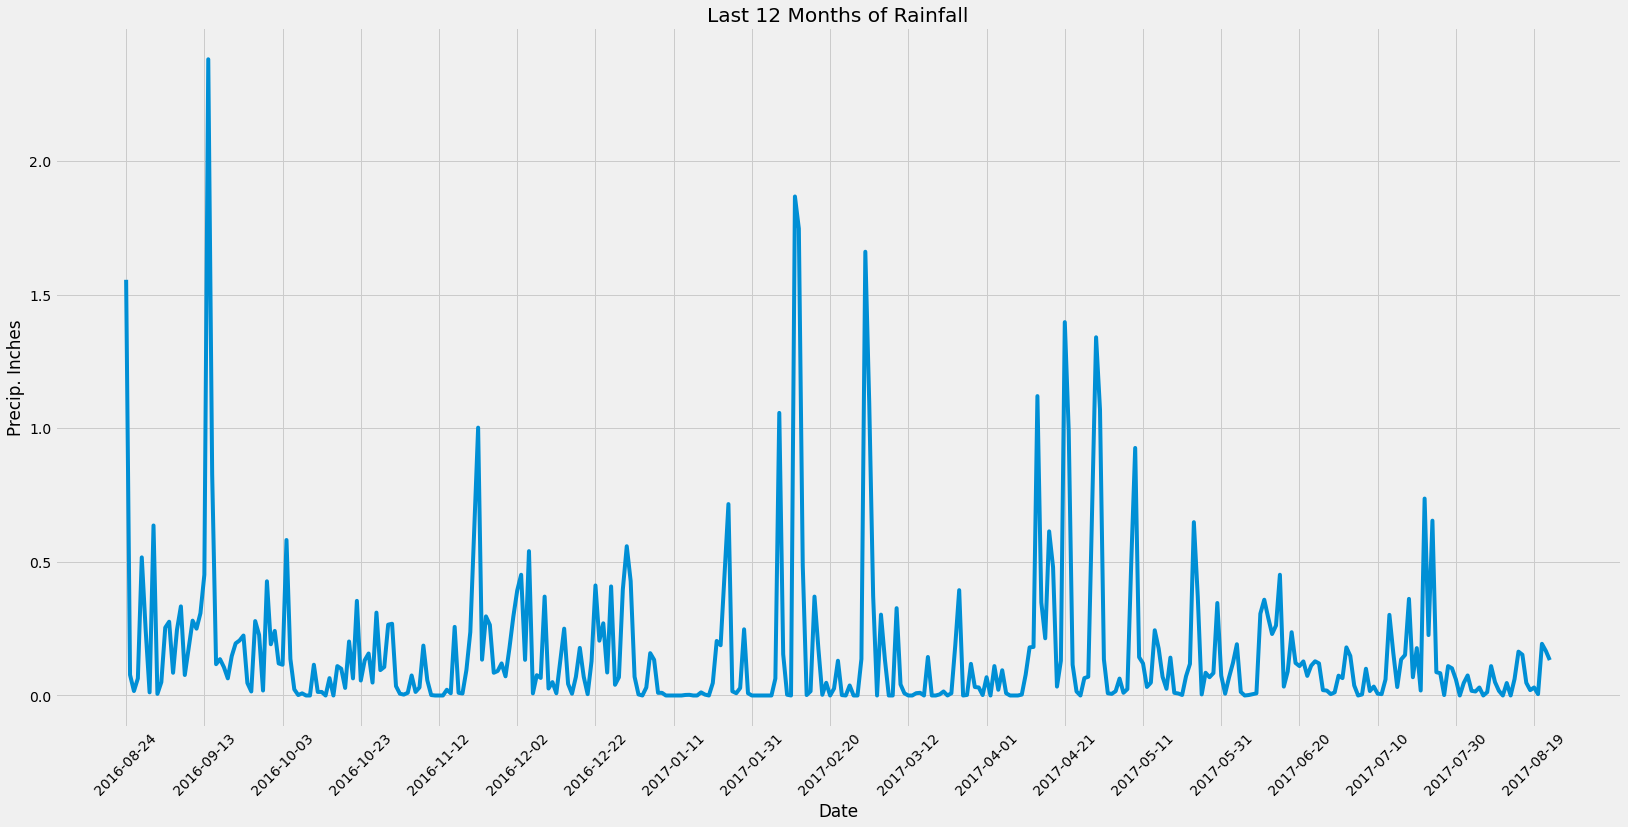

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement,Measurement.date).order_by(Measurement.id.desc()).first()
last_date_yr = last_date[1][0:4]
last_date_mo = last_date[1][5:7]
last_date_day = last_date[1][8:10]
last_date = dt.datetime(int(last_date_yr),int(last_date_mo),int(last_date_day))
year_ago = dt.datetime((int(last_date_yr)-1),int(last_date_mo),int(last_date_day))

# Perform a query to retrieve the data and precipitation scores
last12 = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date>year_ago).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.DataFrame(last12,columns=["Date","Rainfall (in)"])
df = df.set_index("Date")
df = df.sort_index(ascending=False)
mean_precip = df.groupby(df.index).mean()

# Use Pandas Plotting with Matplotlib to plot the data
plt.subplots(figsize =(25, 12))
plt.plot(mean_precip.index,mean_precip)
plt.xlabel("Date")
plt.ylabel("Precip. Inches")
plt.title("Last 12 Months of Rainfall")
plt.xticks(np.arange(0, 365, step=20),rotation=45)
#plt.xticks(np.arange(0, 20, step=1),rotation=90)
#savefig('Visualizations/avg_salaries.png')
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Rainfall (in)
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [Measurement.station, 
       func.count(Measurement.id)]
stat_freq = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
stat_freq

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_stat = stat_freq[0][0]
sel = [Measurement.station,
      func.min(Measurement.tobs),
      func.max(Measurement.tobs),
      func.avg(Measurement.tobs),]
tobs_most_active = session.query(*sel).\
    filter(Measurement.station == most_active_stat).\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
tobs_most_active

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

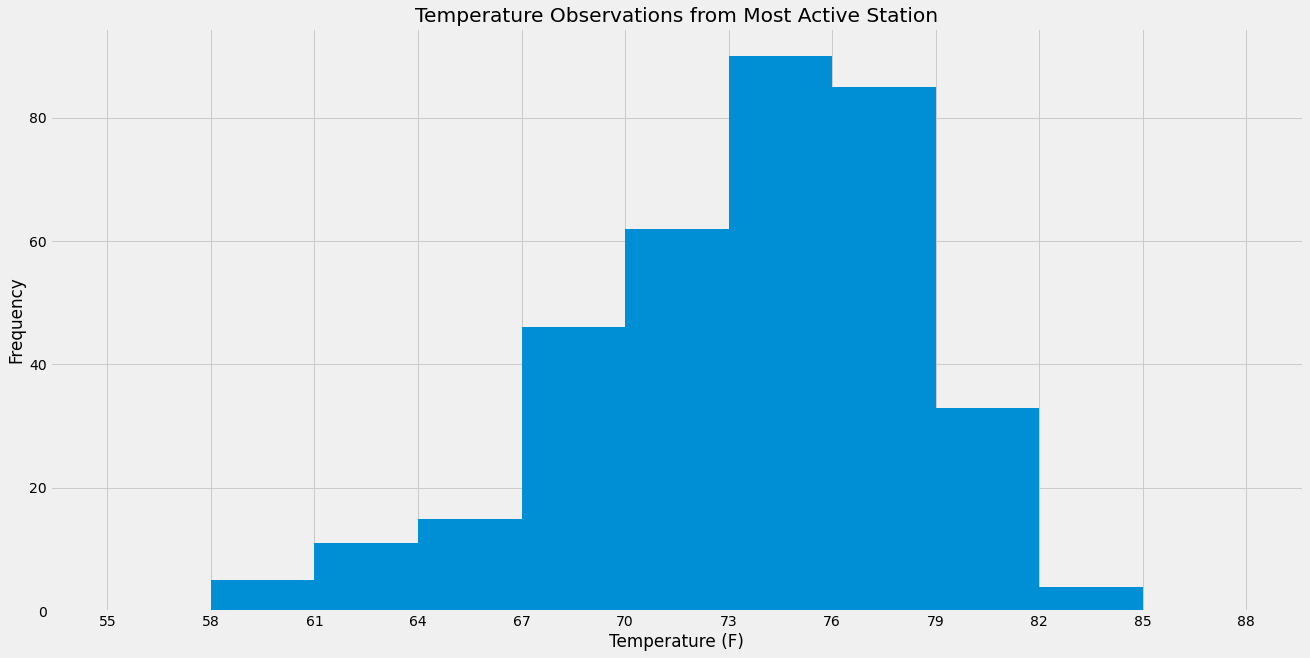

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.date,
      Measurement.tobs]
last12_most_active_stat = session.query(*sel).\
    filter(Measurement.date>year_ago).\
    filter(Measurement.station==most_active_stat)
df_last12_mostact = pd.DataFrame(last12_most_active_stat,columns=["Date","Temperature"])
df_last12_mostact["Temperature"] = df_last12_mostact["Temperature"].astype(int)
bins = list(range(55,90,3))
nameobins = list(range(55,90,3))
fig, ax = plt.subplots(figsize =(20, 10))
ax.hist(df_last12_mostact["Temperature"],bins = bins)
plt.title("Temperature Observations from Most Active Station")
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
ax.set_xticks(bins)
ax.set_xticklabels(nameobins)
#savefig('Visualizations/salary_ranges.png')
plt.show()

## My Vaca

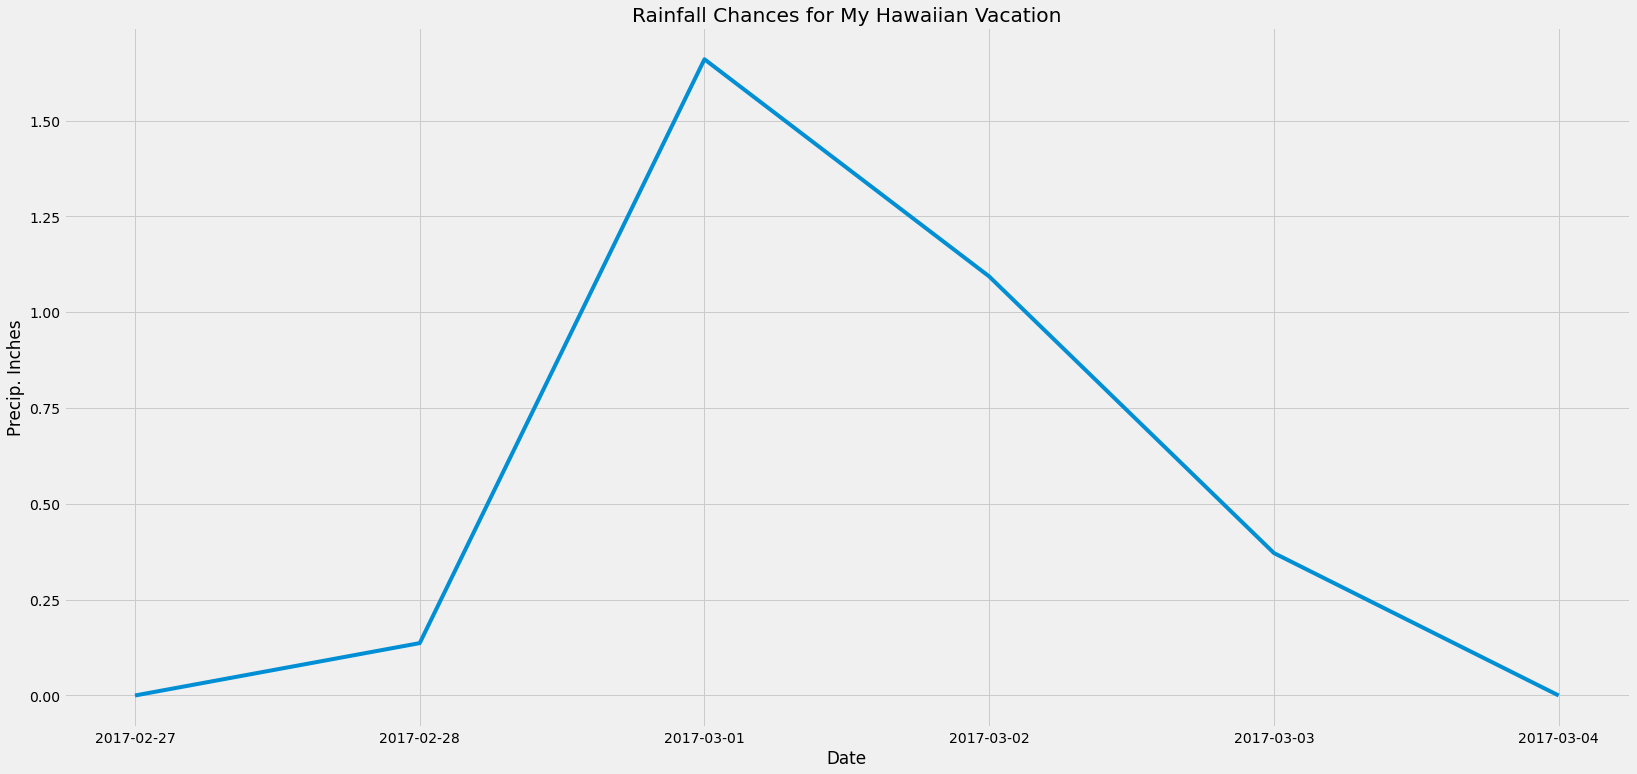

,Precipitation (in)
Date,
2017-02-27,0.000000
2017-02-28,0.136667
2017-03-01,1.660000
2017-03-02,1.093333
2017-03-03,0.371667
2017-03-04,0.000000


In [16]:
vaca_start = dt.datetime(2017,2,26)
vaca_end = dt.datetime(2017,3,4)
sel = [Measurement.date,
      Measurement.prcp]
vaca_weather = session.query(*sel).\
    filter(Measurement.date>=vaca_start).filter(Measurement.date<=vaca_end)
df_vaca = pd.DataFrame(vaca_weather,columns=["Date","Precipitation (in)"])
df_vaca = df_vaca.groupby(by="Date").mean()
plt.subplots(figsize =(25, 12))
plt.plot(df_vaca.index,df_vaca["Precipitation (in)"])
plt.xlabel("Date")
plt.ylabel("Precip. Inches")
plt.title("Rainfall Chances for My Hawaiian Vacation")
#plt.xticks(np.arange(0, 365, step=20),rotation=45)
#plt.xticks(np.arange(0, 20, step=1),rotation=90)
#savefig('Visualizations/avg_salaries.png')
plt.show()
df_vaca

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
